<a href="https://colab.research.google.com/github/johntanas/it1244project/blob/main/code/model_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score,average_precision_score,SCORERS

In [44]:
n_repeats=1
n_splits=5

In [45]:
path_to_max_label="../content/max_label.csv"
path_to_app="../content/cleaned_application.csv"
cleaned_app_df=pd.read_csv(path_to_app,index_col=0)
max_df=pd.read_csv(path_to_max_label,index_col=0)

In [46]:
dep_var="status"
random_state=42

Sort by median income of job to give a ordering to the jobs

In [47]:
order=cleaned_app_df.groupby("job")["income"].median().sort_values()

In [48]:
cleaned_app_df["job"]=cleaned_app_df["job"].replace(order)

In [49]:
train_df=max_df.merge(cleaned_app_df,how="inner",on="id").drop("id",axis=1)

In [50]:
numerical_transformer = StandardScaler()
categorical_transformer=OneHotEncoder()
ord_transformer=OrdinalEncoder()

In [51]:
X,y=train_df.drop(columns=dep_var),train_df[dep_var]

In [52]:
categorical_cols = [cname for cname in X.columns if X[cname].nunique() < 10 and 
                        X[cname].dtype == "object"]
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]


In [140]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('ord',ord_transformer,['job'])
    ])

In [143]:
xs=preprocessor.fit_transform(X)

In [146]:
#https://stackoverflow.com/questions/67554372/get-feature-names-of-columntransformer-using-standarscaler-and-one-hot-encoding
tx = preprocessor.get_params()['transformers']
feature_names = []
for name,transformer,features in tx:
    try:
        Var = preprocessor.named_transformers_[name].get_feature_names().tolist()
        print(Var)
    except AttributeError:
        print(features)
        Var = features
    feature_names = feature_names + Var

['num_child', 'income', 'birth_day', 'employment_length', 'work_phone', 'phone', 'email', 'job', 'CNT_FAM_MEMBERS']
['x0_F', 'x0_M', 'x1_N', 'x1_Y', 'x2_N', 'x2_Y', 'x3_Commercial associate', 'x3_Pensioner', 'x3_State servant', 'x3_Student', 'x3_Working', 'x4_Academic degree', 'x4_Higher education', 'x4_Incomplete higher', 'x4_Lower secondary', 'x4_Secondary / secondary special', 'x5_Civil marriage', 'x5_Married', 'x5_Separated', 'x5_Single / not married', 'x5_Widow', 'x6_Co-op apartment', 'x6_House / apartment', 'x6_Municipal apartment', 'x6_Office apartment', 'x6_Rented apartment', 'x6_With parents']
['job']


In [55]:
score_df=pd.DataFrame()

We will be doing cross validation with StratifiedKFold =5 and 5 repeats.
We use StratifiedKFold instead of Kfold to perserve  the percentage of samples for each class.

In [56]:
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

In [57]:
# dataframe of scores to be converted into plot later
score_df=pd.DataFrame()


* AUC is classification-threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen. 
https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
* Thus we choose AUC as the banks who use the models can determine their own threshold risk probability for bad users and calculate their expected value/loss for these bad users and give them an appropriate interest rate when extending credit to them


There is very little linearity in the imbalanced dataset for the linear dividing line of logisitic regression to work on. This can be seen from the low level of correlation in the table below where all variables have correlation between -0.03 and 0.03 and logisitic regression will be similar to random guessing so we do not try logisitic regression

(array([0.5]), <a list of 1 Text major ticklabel objects>)

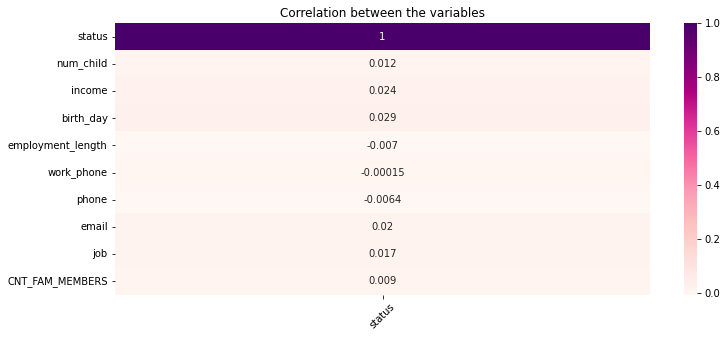

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplots(figsize=(12,5))
status_correlation=train_df.corr()[["status"]]
sns.heatmap(status_correlation,annot=True,cmap='RdPu')
plt.title('Correlation between the variables')
plt.xticks(rotation=45)

We cannot choose k= sqrt(len(X_train)) as it would be very hard to detect the minority class

In [59]:
# try different K values
bestscore=0
bestmodel=None
for i in range(1,6,2):
    scores=[]
    for train_index, test_index in cv.split(xs,y):
          X_train = xs[train_index]
          y_train = y[train_index]
          X_test = xs[test_index]
          y_test = y[test_index]
          model = KNeighborsClassifier(i)
          model.fit(X_train, y_train)  
          y_pred = model.predict(X_test)
          score=roc_auc_score(y_test,y_pred)
          if score>bestscore:
              bestmodel=model
              bestscore=score
              print(f"KNN {i} with best score of {score}")
          scores.append(roc_auc_score(y_test,y_pred))
    score_df["KNN"+str(i)]=scores
    print(f"KNN {i} with avg score of {np.median(np.array(scores))}")

KNN 1 with best score of 0.6395611467138573
KNN 1 with best score of 0.6510423572904145
KNN 1 with best score of 0.6586509247009791
KNN 1 with avg score of 0.6510423572904145
KNN 3 with avg score of 0.626180808104961
KNN 5 with avg score of 0.5899605081264804


Knn with small K (1) is more able to detect the minority class in a imbalanced dataset. However, this would make this model more prone to noise

In [61]:
bestscore=0
bestmodel=None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      model = RandomForestClassifier(random_state=random_state,class_weight ="balanced_subsample")
      model.fit(X_train, y_train )  
      y_pred = model.predict(X_test)
      score=roc_auc_score(y_test,y_pred)
      if score>bestscore:
          bestmodel=model
          bestscore=score
          print(f"RandomForestClassifier with best score of {score}")
      scores.append(roc_auc_score(y_test,y_pred))
score_df["RandomForestClassifier"]=scores
print(f"RandomForestClassifier with avg score of {np.median(np.array(scores))}")

RandomForestClassifier with best score of 0.695799471113277
RandomForestClassifier with best score of 0.6988250067205616
RandomForestClassifier with best score of 0.7115991552879475
RandomForestClassifier with avg score of 0.6960962505032146


Random forests are an ensemble of decision trees and typically do better than decision trees so we do not use decision trees here. The random forest is able to construct association rules with the target, finding some temporal or causal relations.

In [127]:
X.nunique()

gender                  2
own_car                 2
own_realty              2
num_child               9
income                265
income_type             5
education_level         5
family_status           5
house_type              6
birth_day            7183
employment_length    4357
work_phone              2
phone                   2
email                   2
job                     7
CNT_FAM_MEMBERS        10
dtype: int64

In [147]:

def rf_feat_importance(m, feature_names):
    return pd.DataFrame({'cols':feature_names, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(bestmodel, feature_names)
fi[:10]

,cols,imp
2,birth_day,0.227232
3,employment_length,0.199039
1,income,0.154910
36,job,0.034736
8,CNT_FAM_MEMBERS,0.033618
7,job,0.033079
5,phone,0.027321
0,num_child,0.025623
4,work_phone,0.020748
19,x3_Working,0.015215


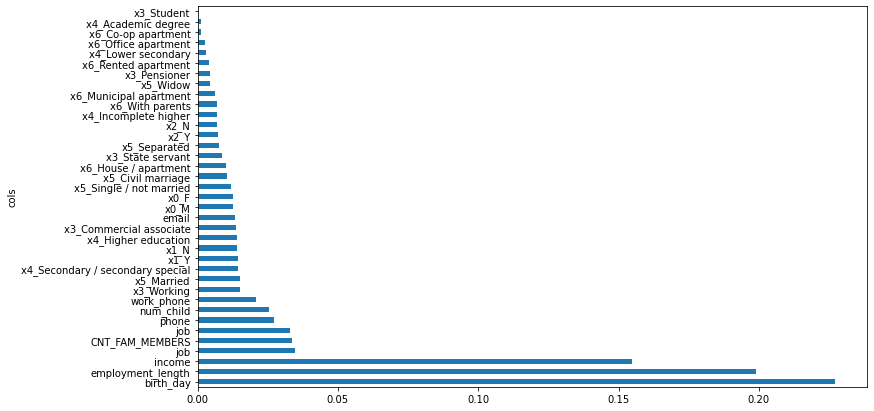

In [148]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi);

birthday , employment length and income are the strong learners for the random forest. The random forest is able to differentiate using these variables

In [62]:
score_df.to_csv("../content/score.csv")

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line and it is one method to deal with imbalanced data
https://arxiv.org/abs/1106.1813

In [63]:
# score Dataframe for model with smote 
score_df_smote=pd.DataFrame()

In [64]:
bestscore=0
bestmodel=None
# we stop at k ==11 as it seems that the knn auc roc score drops off at k=7
for i in range(1,12,2):
    scores=[]
    for train_index, test_index in cv.split(xs,y):
        X_train = xs[train_index]
        y_train = y[train_index]
        X_test = xs[test_index]
        y_test = y[test_index]
        sm = SMOTE()
        X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
        model = KNeighborsClassifier(i)
        model.fit(X_train_oversampled, y_train_oversampled)  
        y_pred = model.predict(X_test)
        score=roc_auc_score(y_test,y_pred)
        scores.append(score)
        if score>bestscore:
            bestmodel=model
            bestscore=score
            print(f"KNN {i} with best score of {score}")
    score_df_smote["KNN"+str(i)]=scores
    print(f"KNN {i} with avg score of {np.median(np.array(scores))}")

KNN 1 with best score of 0.6421882982229109
KNN 1 with best score of 0.6580342774001462
KNN 1 with best score of 0.6639708677249482
KNN 1 with avg score of 0.6580342774001462
KNN 3 with best score of 0.6702242262633993
KNN 3 with avg score of 0.6616074061675554
KNN 5 with best score of 0.6818730798540051
KNN 5 with best score of 0.6844468090193921
KNN 5 with best score of 0.6896404284870008
KNN 5 with avg score of 0.6822963942115194
KNN 7 with avg score of 0.6773755701963844
KNN 9 with avg score of 0.6730782818922102
KNN 11 with avg score of 0.6719683021361604


Smote works by using a random example from the minority class which is first chosen. Then k of the nearest neighbors for that example are found (k=5 is the default value which is used here). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space. Thus, smote is essentially overfitting our KNN classifier
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [66]:
bestscore=0
bestmodel=None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      sm = SMOTE()
      X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
      model = RandomForestClassifier(random_state=random_state)
      model.fit(X_train_oversampled, y_train_oversampled)  
      y_pred = model.predict(X_test)
      score=roc_auc_score(y_test,y_pred)
      scores.append(score)
      if score>bestscore:
            bestmodel=model
            bestscore=score
            print(f"RandomForestClassifier with best score of {score}")
score_df_smote["RandomForestClassifier"]=scores
print(f"RandomForestClassifier with avg score of {np.median(np.array(scores))}")

RandomForestClassifier with best score of 0.6638890130506138
RandomForestClassifier with best score of 0.6719052629061955
RandomForestClassifier with best score of 0.6808731710799175
RandomForestClassifier with avg score of 0.6690251170664664


In [ ]:
fi = rf_feat_importance(bestmodel, feature_names)
fi[:10]

In [ ]:
plot_fi(fi)

Surpisingly, smote actually deproves auc score for random forest but improves knn, suggesting that the orginial data is quite noisy, and creating sythenic data will only add on to the noise.

In [67]:
score_df_smote.to_csv("../content/score_smote.csv")

Thus,we could also try totem links on knn and rf.

In [68]:
from imblearn.under_sampling import TomekLinks

In [69]:
#totem link dataframe
score_df_tl=pd.DataFrame()

In [70]:
bestscore=0
bestmodel=None
scores=[]
# we stop at k ==9 as it seems that the knn auc roc score drops off at k=7
for i in range(1,10,2):
    scores=[]
    for train_index, test_index in cv.split(xs,y):
        X_train = xs[train_index]
        y_train = y[train_index]
        X_test = xs[test_index]
        y_test = y[test_index]
        tl = TomekLinks()
        X_train_undersampled, y_train_undersampled = tl.fit_resample(X_train, y_train)
        model = KNeighborsClassifier(i)
        model.fit(X_train_undersampled, y_train_undersampled)  
        y_pred = model.predict(X_test)
        score=roc_auc_score(y_test,y_pred)
        scores.append(score)
        if score>bestscore:
            bestmodel=model
            bestscore=score
            print(f"KNN {i} with best score of {score}")
    score_df_tl["KNN"+str(i)]=scores
    print(f"KNN {i} with avg score of {np.median(np.array(scores))}")

KNN 1 with best score of 0.6501058551593057
KNN 1 with best score of 0.6592387252163441
KNN 1 with best score of 0.6657975684091028
KNN 1 with avg score of 0.6592387252163441
KNN 3 with avg score of 0.6293622953035358
KNN 5 with avg score of 0.5919140706953546
KNN 7 with avg score of 0.5670368354962507
KNN 9 with avg score of 0.5449853012421021


KNN with k=1 is prone to overfitting.

In [75]:
bestscore=0
bestmodel=None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      tl = TomekLinks()
      X_train_undersampled, y_train_undersampled = tl.fit_resample(X_train, y_train)
      model = RandomForestClassifier(random_state=random_state)
      model.fit(X_train_undersampled, y_train_undersampled)   
      y_pred = model.predict(X_test)
      score=roc_auc_score(y_test,y_pred)
      scores.append(score)
      if score>bestscore:
            bestmodel=model
            bestscore=score
            print(f"RandomForestClassifier with best score of {score}")
score_df_tl["RandomForestClassifier"]=scores
print(f"RandomForestClassifier with avg score of {np.median(np.array(scores))}")

RandomForestClassifier with best score of 0.6336522047714175
RandomForestClassifier with best score of 0.6494142061440787
RandomForestClassifier with avg score of 0.6391935050803386


Totem links undersample and we lose infomation, causing the models to perform worser.

In [72]:
score_df_tl.to_csv("../content/score_tl.csv")